In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, _safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
import os
from pathlib import Path
from sklearn.model_selection import cross_val_score

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [3]:
os.getcwd()

'/Users/armandoassembleia/Desktop/rsmotenc/analysis/notebook'

# Set folder paths for outputs

In [4]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'models')
REPORTS = Path(REPO_ROOT / 'reports' / 'bank')

In [5]:
MODELS = Path(REPO_ROOT / 'models')

In [6]:
os.chdir('..')
PATH_1 = Path(os.getcwd())
#os.chdir('..')
#Path(os.getcwd())

In [7]:
from core.distMix import distmix
from scipy.spatial.distance import cdist
from core.Balance import BalanceDataset
from core.auxSamplingStudy import *

core.distMix


In [8]:
#os.chdir(PATH_1)
#Path(os.getcwd())

# Read the file

In [9]:
df= pd.read_csv(DATA / 'bank_additional_full.csv')

In [10]:
df= remove_outlier(df, 'age', 2.5)
df= remove_outlier(df, 'campaign', 2.5)
df= remove_outlier(df, 'emp.var.rate', 2.5)
df= remove_outlier(df, 'cons.price.idx', 2.5)
df= remove_outlier(df, 'cons.conf.idx', 2.5)
df= remove_outlier(df, 'euribor3m', 2.5)
df= remove_outlier(df, 'nr.employed', 2.5)

In [11]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [12]:
is_pdays_999 = df['pdays'] == 999
df.loc[is_pdays_999, 'pdays_c'] = "never contacted"
df.loc[~is_pdays_999, 'pdays_c'] = pd.qcut(df.loc[~is_pdays_999, 'pdays'], 4, labels=["very recently contacted","recently contacted", "moderately recently contacted", "contacted long ago"])
df[['pdays_c', 'pdays']]

df.drop('pdays', 1, inplace= True)

In [13]:
is_previous_0 = df['previous'] == 0
df.loc[is_previous_0, 'previous_c'] = "never contacted"
df.loc[~is_previous_0, 'previous_c'] = pd.cut(df.previous,bins=[0, 1, 4, 7],labels=["contacted once", "rarely contacted", "frequently contacted"])
df[['previous_c', 'previous']]

df.drop('previous', 1, inplace= True)

In [14]:
#### In order to feed the data to any machine learning method, 
### it's convenient to change strings to numeric values. So, we are going to change 'no' to 0 and 'yes' to 1
is_purchased = df['y'] == 'yes'
df.loc[is_purchased, 'target'] = 1
df.loc[~is_purchased, 'target'] = 0
df[['target', 'y']]
df.drop('y', 1, inplace= True)

In [15]:
df_num= df[['age','duration','campaign','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','target']]
corr_num = df_num.corr()
corr_num

age  duration  campaign  emp.var.rate  cons.price.idx  \
age             1.000000 -0.006561  0.006875      0.081826        0.054775   
duration       -0.006561  1.000000 -0.037328     -0.014408        0.005740   
campaign        0.006875 -0.037328  1.000000      0.101920        0.087973   
emp.var.rate    0.081826 -0.014408  0.101920      1.000000        0.845136   
cons.price.idx  0.054775  0.005740  0.087973      0.845136        1.000000   
cons.conf.idx   0.109962 -0.012044 -0.007239      0.328424        0.190927   
euribor3m       0.092023 -0.017155  0.081965      0.978759        0.805977   
nr.employed     0.077782 -0.024651  0.095540      0.954690        0.735563   
target         -0.024210  0.423297 -0.046072     -0.257349       -0.185322   

                cons.conf.idx  euribor3m  nr.employed    target  
age                  0.109962   0.092023     0.077782 -0.024210  
duration            -0.012044  -0.017155    -0.024651  0.423297  
campaign            -0.007239   0.081965     0.095540 -0.046072  
emp.var.rate         0.328424   0.978759     0.954690 -0.257349  
cons.price.idx       0.190927   0.805977     0.735563 -0.185322  
cons.conf.idx        1.000000   0.397912     0.217505  0.027898  
euribor3m            0.397912   1.000000     0.962600 -0.248442  
nr.employed          0.217505   0.962600     1.000000 -0.274426  
target               0.027898  -0.248442    -0.274426  1.000000

In [16]:
# emp.var.rate and nr.employed are highly correlated with euribor3m. 
# That's why former two are removed to get rid of multi-collinearity.
# Duration column is substantially correlated to target 
# and could be a good predictor of target outcome. 
# However, one can not know call duration before making the call. 
# That's why this column is removed so that the model can generalise on unseen data

In [17]:
df.drop('duration',1,inplace=True)
df.drop('emp.var.rate',1,inplace=True)
df.drop('nr.employed',1,inplace=True)

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df_feature= df.drop('target',1)
df_target= df[['target']]

In [20]:
print(Counter(df['target']))

Counter({0.0: 32599, 1.0: 3519})


In [21]:
# Num of minority instances is 3519 and majority instances is 32599

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder

# Create helper functions

In [23]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#randomforest model - hyperparameter tuning using grid search
param_grid = {
'max_depth': [10], 'max_features': [5, 10],
'min_samples_leaf': [3, 5], 'min_samples_split': [2, 4], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

In [24]:
encoded_df = MultiColumnLabelEncoder(columns = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
                                               'poutcome', 'pdays_c', 'previous_c']).fit_transform(df)


In [25]:
encoded_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'poutcome',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'pdays_c', 'previous_c',
       'target'],
      dtype='object')

In [26]:
anovap_value = list()
for cols in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
                                               'poutcome', 'pdays_c', 'previous_c']:
    statistic, p = stats.f_oneway(encoded_df[cols], encoded_df['target'])
    anovap_value.append(tuple([cols, p]))
    
print(anovap_value)

[('job', 0.0), ('marital', 0.0), ('education', 0.0), ('default', 0.0), ('housing', 0.0), ('loan', 0.0), ('contact', 0.0), ('month', 0.0), ('day_of_week', 0.0), ('poutcome', 0.0), ('pdays_c', 0.0), ('previous_c', 0.0)]


In [27]:
from scipy.stats import chi2_contingency
chi2p_value = list()
for cols in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
                                               'poutcome', 'pdays_c', 'previous_c']:
    obs = pd.crosstab(encoded_df[cols], encoded_df['target'])
    g, p, dof, expctd = chi2_contingency(obs)
    chi2p_value.append(tuple([cols, p]))
    
print(chi2p_value)

[('job', 8.274959557723803e-85), ('marital', 1.0490021676190478e-27), ('education', 4.722556979141996e-30), ('default', 2.396736751936363e-56), ('housing', 0.019146278089660962), ('loan', 0.13725167724069698), ('contact', 3.456262374450821e-129), ('month', 0.0), ('day_of_week', 0.0019573310174748654), ('poutcome', 0.0), ('pdays_c', 0.0), ('previous_c', 7.705708237314738e-209)]


In [28]:
encoded_df= encoded_df.drop('target',1)

In [29]:
1 - 2000 / encoded_df.shape[0]

0.9446259482806357

In [30]:
np.sum(df_target)/df_target.shape[0]

target    0.097431
dtype: float64

In [31]:
#Sampling: Added by me
encoded_df, aux1, df_target, aux2 = train_test_split(encoded_df, df_target, test_size=0.95, random_state=12)

In [32]:
df_target.shape

(1805, 1)

In [33]:
np.sum(df_target)

target    153.0
dtype: float64

In [34]:
np.sum(df_target)/df_target.shape[0]

target    0.084765
dtype: float64

In [35]:
1/12

0.08333333333333333

In [36]:
# Split the raw data into train and test set. Split ratio = 75:25
X_train, X_test, y_train, y_test = train_test_split(encoded_df, df_target, test_size=0.25, random_state=12)

In [37]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [38]:
X_train.shape

(1353, 17)

In [39]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased

columns = [0,10,12,13,14]
name_columns = X_train.columns[columns]

sc = StandardScaler()
X_train[name_columns] = sc.fit_transform(X_train[name_columns])
X_test[name_columns] = sc.transform(X_test[name_columns])

In [40]:
X_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=col_list)
X_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=col_list)

In [41]:
X_train.shape

(1353, 17)

In [42]:
X_train
nbinsA = calculate_nbins(X_train, [1,2,3,4,5,6,7,8,9,11,15,16], "average")
nbinsFD = calculate_nbins(X_train, [0, 10, 12, 13, 14], "FD")
print(nbinsA)
print(nbinsFD)

[12, 4, 7, 2, 3, 3, 2, 10, 5, 3, 5, 3]
[18.565461902254313, 22.120550351622153, 13.623755711662934, 17.731552265982824, 6.856686340009988]
4
17


In [43]:
## Apply the random-forest classifier along with the NEW SMOTE method
filename = (MODELS / 'bank_mysmotenc.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [1,2,3,4,5,6,7,8,9,11,15,16]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = 1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.1s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.2s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.1s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=

In [44]:
## Apply the random-forest classifier along with the existng SMOTE-NC method
filename = (MODELS / 'bank_smotenc.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [1,2,3,4,5,6,7,8,9,11,15,16]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.8s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.0s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.8s
[CV] END randomforestclassifier__max_depth=10, rando

/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.5s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.6s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   1.7s
[CV] END randomforestclassifier__max_depth=10, rando

/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.8s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.7s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.9s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=5, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   1.9s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.2s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.4s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.6s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.2s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.3s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.3s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.4s


/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/opt/anaconda3/lib/python3.7/site-packages/imblearn/pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=500; total time=   2.4s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=10, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=500; total time=   2.5s
[CV] END randomforestclassifier__max_depth=10, r

In [43]:
dict_methods = {"gower": {"method": "gower", "weigths_boolean": False, "nbins":3},
                "huang": {"method": "huang", "weigths_boolean": False, "nbins":3},
                "ahmadA": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadFD": {"method": "ahmad", "weigths_boolean": True, "nbins":nbinsFD},
                "ahmadMahA": {"method": "ahmad_mahalanobis", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadMahFD": {"method": "ahmad_mahalanobis", "weigths_boolean": True, "nbins":nbinsFD},
                "ahmadL1A": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsA},
                "ahmadL1FD": {"method": "ahmad_l1", "weigths_boolean": True, "nbins":nbinsFD}
                }              

methods_saved = []

for name, dict_info in dict_methods.items():

    filename = (MODELS / f'bank_rsmotenc_{name}.sav')
    samp_pipeline = make_pipeline(BalanceDataset(cat_vars = X_train.columns[[1,2,3,4,5,6,7,8,9,11,15,16]], method=dict_info["method"], weigths_boolean = dict_info["weigths_boolean"], nbins=dict_info["nbins"]), 
                                RandomForestClassifier(random_state=42))
    # check model performance on different values of hyper-parameters.
    grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                            return_train_score=True, n_jobs = 1, verbose = 2)
    grid_search.fit(X_train, y_train)
    best_grid = grid_search.best_estimator_
    pickle.dump(best_grid, open(filename, 'wb'))

    methods_saved.append(name)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
(1082, 17)
(95, 17)
[[0.         0.3930127  0.57852455 ... 0.3039279  0.1302561  0.44945697]
 [0.3930127  0.         0.53828894 ... 0.37424261 0.38791305 0.27436528]
 [0.57852455 0.53828894 0.         ... 0.4528969  0.53212327 0.38157071]
 ...
 [0.3039279  0.37424261 0.4528969  ... 0.         0.31653693 0.42270291]
 [0.1302561  0.38791305 0.53212327 

In [49]:
filename

PosixPath('/Users/armandoassembleia/Desktop/rsmotenc/analysis/models/bank_rsmotenc_AhmadL1A.sav')

In [48]:
loaded_model = pickle.load(open(filename, 'rb'))

ModuleNotFoundError: No module named 'Sampling_Methods'

In [47]:
for loaded_model in loaded_models.values():
    print("ok")

ok


In [46]:
## Evaluate SMOTE-NC performance on train and test set

filename1 = (MODELS / 'bank_smotenc.sav')
filename2 = (MODELS / 'bank_mysmotenc.sav')
#filename = pickle.load(open(filename, 'rb'))
loaded_models = {"SMOTENC" : pickle.load(open(filename1, 'rb')),
                 "SMOTEENC": pickle.load(open(filename2, 'rb'))}

print('                RF performance Report')

#best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model, "f1Score_1")
#print("Best Threshold: ", best_threshold)
#evaluate(X_train, y_train, loaded_model, best_threshold)

#best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model, "f1ScoreIR")

k = evaluate_table(X_test, y_test, loaded_models, ["f1ScoreIR", "Precision0"], save=None)

#print("Best Threshold: ", best_threshold)
#evaluate(X_test, y_test, loaded_model, best_threshold)

#loaded_model.steps[1][1].feature_importances_

                RF performance Report
Confusion Matrix : 
 [[ 13  11]
 [ 21 407]]
Accuracy :  0.929
F1-Score IR :  0.487
F1-Score Recall IR :  0.401
Class 1
Precision :  0.542
Sensitivity :  0.382
F1-Score :  0.448
Class 0
Precision :  0.951
Sensitivity :  0.974
F1-Score :  0.962
{'Confusion Matrix': array([[ 13,  11],
       [ 21, 407]]), 'Accuracy': 0.929, 'Precision0': 0.951, 'Sensitivity0': 0.974, 'Precision1': 0.542, 'Sensitivity1': 0.382, 'Specificity': 0.974, 'f1Score0': 0.962, 'f1Score1': 0.448, 'f1ScoreIR': 0.487, 'f1ScoreRecallIR': 0.401}
Confusion Matrix : 
 [[ 21  33]
 [ 13 385]]
Accuracy :  0.898
F1-Score IR :  0.512
F1-Score Recall IR :  0.633
Class 1
Precision :  0.389
Sensitivity :  0.618
F1-Score :  0.477
Class 0
Precision :  0.967
Sensitivity :  0.921
F1-Score :  0.944
{'Confusion Matrix': array([[ 21,  33],
       [ 13, 385]]), 'Accuracy': 0.898, 'Precision0': 0.967, 'Sensitivity0': 0.921, 'Precision1': 0.389, 'Sensitivity1': 0.618, 'Specificity': 0.921, 'f1Score0': 

In [47]:
k

f1ScoreIR  Precision0
SMOTENC       0.487       0.951
SMOTEENC      0.512       0.967

In [68]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'bank_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

#best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model)
#print("Best Threshold: ", best_threshold)
#evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model, "f1ScoreIR")
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.45
Confusion Matrix : 
 [[ 21  33]
 [ 13 385]]
Accuracy :  0.898
F1-Score IR :  0.512
F1-Score Recall IR :  0.633
Class 1
Precision :  0.389
Sensitivity :  0.618
F1-Score :  0.477
Class 0
Precision :  0.967
Sensitivity :  0.921
F1-Score :  0.944


array([0.06488935, 0.06459276, 0.03889913, 0.03952045, 0.00930027,
       0.02570004, 0.03085398, 0.07444521, 0.05852704, 0.05148291,
       0.11398798, 0.03606655, 0.08500829, 0.10369629, 0.18454733,
       0.00838143, 0.01010098])

In [61]:
methods_saved

['gower', 'huang', 'ahmad3', 'ahmad10', 'ahmadMah3', 'ahmadMah10']

In [53]:
np.sum(y_train == 0.0)

target    1234
dtype: int64

In [53]:
filename = (MODELS / 'bank_rsmotenc_gower.sav')
loaded_model = pickle.load(open(filename, 'rb'))
print('                RF performance Report')

#best_threshold = evaluate_best_threshold(X_train, y_train, loaded_model, "f1ScoreIR")
#print("Best Threshold: ", best_threshold)
#evaluate(X_train, y_train, loaded_model, best_threshold)

best_threshold = evaluate_best_threshold(X_test, y_test, loaded_model, "f1ScoreIR")
print("Best Threshold: ", best_threshold)
evaluate(X_test, y_test, loaded_model, best_threshold)

loaded_model.steps[1][1].feature_importances_

                RF performance Report
Best Threshold:  0.30000000000000004
Confusion Matrix : 
 [[ 19  24]
 [ 15 394]]
Accuracy :  0.914
F1-Score IR :  0.528
F1-Score Recall IR :  0.576
Class 1
Precision :  0.442
Sensitivity :  0.559
F1-Score :  0.494
Class 0
Precision :  0.963
Sensitivity :  0.943
F1-Score :  0.953


array([0.058174  , 0.02227778, 0.00879352, 0.01465084, 0.0017146 ,
       0.02159556, 0.00576365, 0.00771611, 0.04870859, 0.03362531,
       0.0178584 , 0.04019859, 0.02516518, 0.11596897, 0.34503806,
       0.22882362, 0.00392723])

In [33]:
# Compare variable importance between SMOTE-NC and SMOTE-ENC
filename = (MODELS / 'bank_mysmotenc.sav')
loaded_model1 = pickle.load(open(filename, 'rb'))
filename = (MODELS / 'bank_smotenc.sav')
loaded_model2 = pickle.load(open(filename, 'rb'))
feature_df = pd.DataFrame(np.vstack((loaded_model1.steps[1][1].feature_importances_,loaded_model2.steps[1][1].feature_importances_,
                         (loaded_model1.steps[1][1].feature_importances_ - loaded_model2.steps[1][1].feature_importances_))))
feature_df.index = ('new', 'old', 'imp_increase')
feature_df.columns = X_train.columns
feature_df

age       job   marital  education   default   housing  \
new           0.039529  0.031847  0.019064   0.025330  0.036658  0.005546   
old           0.035254  0.063283  0.014519   0.021541  0.056420  0.005649   
imp_increase  0.004275 -0.031435  0.004545   0.003789 -0.019761 -0.000103   

                  loan   contact     month  day_of_week  campaign  poutcome  \
new           0.055076  0.049164  0.043328     0.041261  0.028770  0.035327   
old           0.048542  0.072722  0.041084     0.026772  0.060094  0.031156   
imp_increase  0.006534 -0.023557  0.002243     0.014489 -0.031324  0.004171   

              cons.price.idx  cons.conf.idx  euribor3m   pdays_c  previous_c  
new                 0.111663       0.103674   0.358428  0.007975    0.007360  
old                 0.102897       0.098708   0.310438  0.003921    0.007002  
imp_increase        0.008766       0.004966   0.047990  0.004054    0.000359

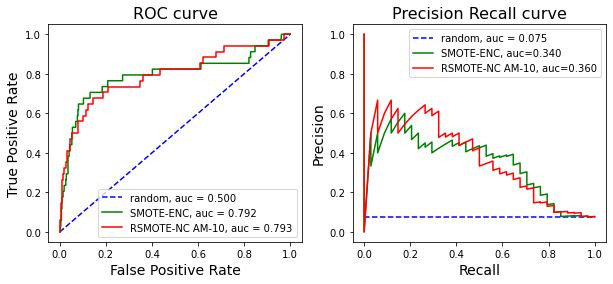

In [61]:
##Create ROC-AUC and PR-AUC curve
dict_models = {"SMOTE-ENC": MODELS / 'bank_mysmotenc.sav',
                "RSMOTE-NC AM-10": MODELS / 'bank_rsmotenc_gower.sav'}

#generate_curves(dict_models, X_test, y_test,save = REPORTS / "bank_roc_prc.jpeg")
generate_curves(dict_models, X_test, y_test)

<Figure size 720x720 with 0 Axes>

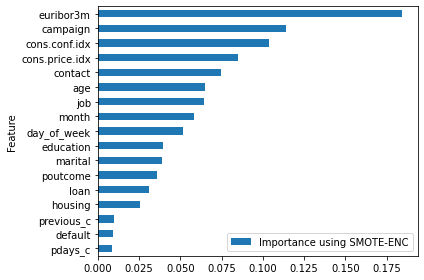

In [44]:
## Plot feature importance using our new SMOTE-ENC method

filename = (MODELS / 'bank_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Importance using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'bank_mysmotenc.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

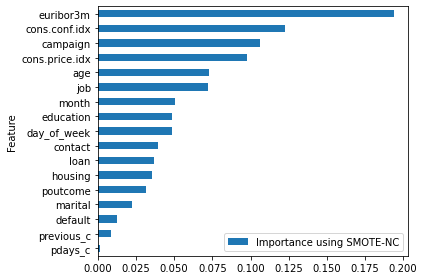

In [43]:
## Plot feature importance using the existing SMOTE-NC method

filename = (MODELS / 'bank_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Importance using SMOTE-NC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'bank_smotenc.jpeg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

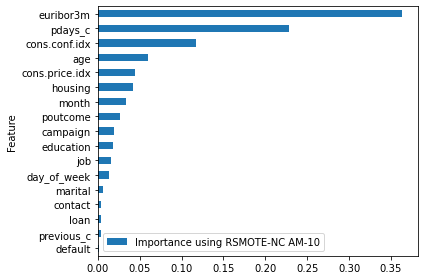

In [48]:
filename = (MODELS / 'bank_rsmotenc_ahmadMah10.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(20))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Importance using RSMOTE-NC AM-10']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'bank_rsmotenc_ahmadMah10.jpeg', bbox_inches='tight')

In [47]:
filename = (MODELS / 'bank_mysmotenc.sav')
model1 = pickle.load(open(filename, 'rb'))

filename = (MODELS / 'bank_rsmotenc_ahmadMah10.sav')
model2 = pickle.load(open(filename, 'rb'))

for scoring in ('precision', 'precision_micro', 'precision_macro',
                'f1', 'f1_micro', 'f1_macro', 'f1_weighted', 
                'recall_micro', 'recall_weighted'):
    
    cv_scoremodel1 = cross_val_score(model1, X_train, y_train, cv=kfold, scoring = scoring)
    cv_scoremodel2 = cross_val_score(model2, X_train, y_train, cv=kfold, scoring = scoring)
    t, p = stats.ttest_ind(cv_scoremodel1, cv_scoremodel2, equal_var = True)
    print(scoring, t, p)
    
    

[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
---------------------------
Weigths calculated
Inv cov time:  0.0005559921264648438
Mahalanobis arrays time:  0.049263954162597656
False
True
[[0.         2.26193382 2.45398906 ... 3.06418418 1.04609713 2.0608823 ]
 [2.26193382 0.         3.16619426 ... 3.14044385 2.12934325 2.03878125]
 [2.45398906 3.16619426 0.         ... 1.68885402 3.25482577 1.87103631]
 ...
 [3.06418418 3.14044385 1.68885402 ... 0.         3.76214294 2.73889887]
 [1.04609713 2.12934325 3.25482577 ... 3.76214294 0.         2.26146161]
 [2.0608823  2.03878125 1.87103631 ... 2.73889887 2.26146161 0.        ]]
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  2.0786707401275635
Cat finished
---------------------------
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
[0, 10, 12, 

In [36]:
idnum = [0,10,12,13,14]
idbin = []
idcat = [1,2,3,4,5,6,7,8,9,11,15,16]

data = encoded_df.to_numpy()

distance_matrices = {"Euclidean": cdist(data.astype(np.float16),data.astype(np.float16)),
                    "Gower" : distmix(data, method = "gower", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Huang" : distmix(data, method = "huang", weigths_boolean = False, nbins=0, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 3": distmix(data, method = "ahmad", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad - 10": distmix(data, method = "ahmad", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 3" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=3, idnum = idnum, idbin = idbin, idcat = idcat ),
                    "Ahmad Mah - 10" : distmix(data, method = "ahmad_mahalanobis", weigths_boolean = True, nbins=10, idnum = idnum, idbin = idbin, idcat = idcat )}

[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
---------------------------
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Cat finished
---------------------------
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calculating coocccur...
Same DataFrame
Cooccur time:  5.520956993103027
Cat finished
---------------------------
[0, 10, 12, 13, 14]
[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 16]
---------------------------
Weigths calculated
Distance matrix calculated
---------------------------
Binary finished
---------------------------
Calcula

In [37]:
np.sum(df_target)

target    153.0
dtype: float64

0.3006535947712418
0.26143790849673204
0.3137254901960784
0.23529411764705882
0.3790849673202614
0.22875816993464052
0.22875816993464052


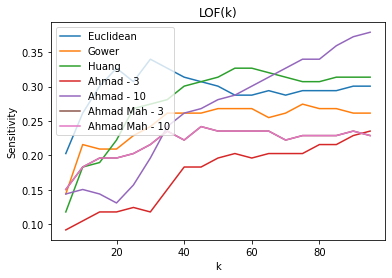

0.39215686274509803
0.3202614379084967
0.40522875816993464
0.2549019607843137
0.45098039215686275
0.27450980392156865
0.27450980392156865


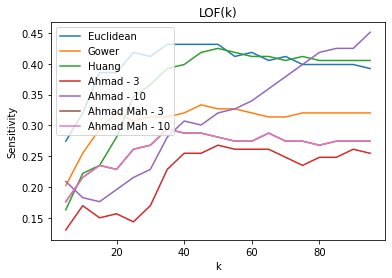

0.45751633986928103
0.35294117647058826
0.45751633986928103
0.30718954248366015
0.48366013071895425
0.33986928104575165
0.33986928104575165


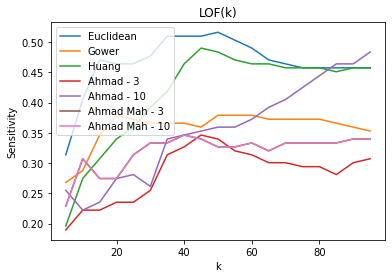

In [38]:
outlier_prevelance = 153
index = encoded_df.index
neigbs = list(range(5,100,5))
metric = "Sensitivity"

test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance, metric, save = REPORTS / "bank_distances100.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, int(outlier_prevelance*1.5), metric, save = REPORTS / "bank_distances150.jpeg")
test_distances(distance_matrices, df_target, index, neigbs, outlier_prevelance*2, metric, save = REPORTS / "bank_distances200.jpeg")